In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_validate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The best parameters are： {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

 LBP-KNN Each fold result for the 5-fold cross vallidation：

Fold 1:
LBP-KNN Accuracy Fold 1: 52.73%
LBP-KNN Precision Fold 1: 53.20%
LBP-KNN Recall Fold 1: 52.72%
LBP-KNN F1-score Fold 1: 51.95%

Fold 2:
LBP-KNN Accuracy Fold 2: 53.93%
LBP-KNN Precision Fold 2: 54.54%
LBP-KNN Recall Fold 2: 53.92%
LBP-KNN F1-score Fold 2: 53.47%

Fold 3:
LBP-KNN Accuracy Fold 3: 56.20%
LBP-KNN Precision Fold 3: 56.92%
LBP-KNN Recall Fold 3: 56.20%
LBP-KNN F1-score Fold 3: 55.68%

Fold 4:
LBP-KNN Accuracy Fold 4: 52.97%
LBP-KNN Precision Fold 4: 53.51%
LBP-KNN Recall Fold 4: 52.97%
LBP-KNN F1-score Fold 4: 52.49%

Fold 5:
LBP-KNN Accuracy Fold 5: 54.17%
LBP-KNN Precision Fold 5: 54.65%
LBP-KNN Recall Fold 5: 54.17%
LBP-KNN F1-score Fold 5: 53.90%

 LBP-KNN Average results for 5-fold cross validation：
LBP-KNN 5-Fold Accuracy Average: 54.00%
LBP-KNN 5-Fold Precision Average: 54.56%
LBP-KNN 5-Fold Recall Average: 5

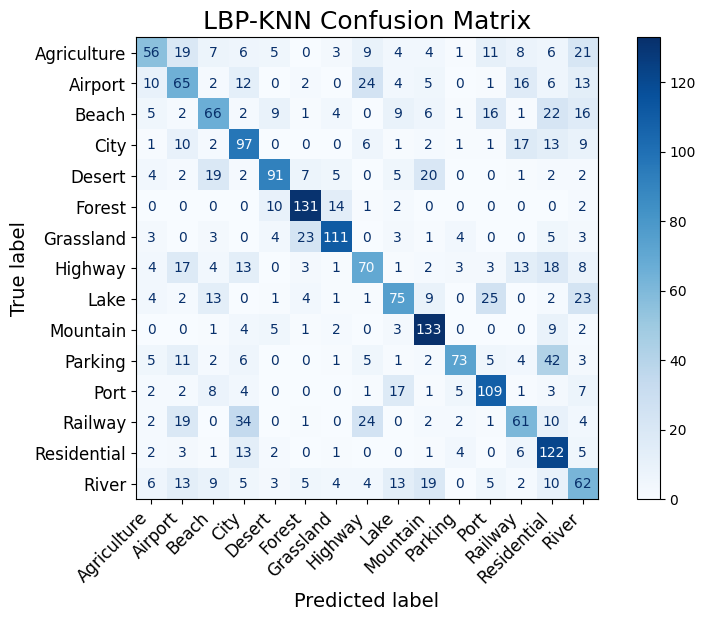

In [ ]:
# file path
trainSet_path = '/content/drive/MyDrive/COMP9517_ZXCZH/train'
testSet_path = '/content/drive/MyDrive/COMP9517_ZXCZH/test'

# LBP parameters, after comparing the training results, we find that radius=2 and num_points=16 is the quickest while ensurinrg the reasonable accuracy
NUM_POINTS = 16
RADIUS = 2

# extract the LBP features:
def extract_lbp_features(image, num_points=NUM_POINTS, radius=RADIUS):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get the lbp features.
    lbp = local_binary_pattern(gray, num_points, radius, method="uniform")
    n_bins = int(lbp.max() + 1)
    # Get the histogram of bins
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    # Do the normalization
    hist = hist / np.sum(hist)
    return hist

# Load and process the datasets:
def load_and_extract_features(dataset_path):
    features = []
    labels = []

    # only load the files in the catagory file.
    categories = [category for category in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path, category))]
    for label, category in enumerate(categories):
        # Find the target path
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue
        # We get each images in the category folder
        for file_name in os.listdir(category_path):
            # Load the image
            file_path = os.path.join(category_path, file_name)
            image = cv2.imread(file_path)
            # Ensure image is avaliable.
            if image is None:
                print(f"Image is invalid!!: {file_path}")
                continue
            # Extract and record the lbp features:
            features.append(extract_lbp_features(image))
            labels.append(label)
    # return nparray data type X_train/y_train/corresponding label
    return np.array(features), np.array(labels), categories

# Get the corresponding training and test dataset
X_train, y_train, categories = load_and_extract_features(trainSet_path)
X_test, y_test, _ = load_and_extract_features(testSet_path)

# Use GridSearchCV to search the best parameters in KNN, we list different n_neighbors, weights and metrics.
param_grid = {
    'n_neighbors': [7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("The best parameters are：", best_params)

# After this we get the best parameters in this mission is {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}.
# After GridSearchCV, we applied the KNN classifier using the best parameters:
knn = KNeighborsClassifier(**best_params)

# ——————————————5-fold cross validation—————————————————————————————————————————
# We include 5-fold cross validation for evaluating the classification performance.
# Using various metrics to evaluate: 'accuracy', 'precision_macro', 'recall_macro' and f1_macro'
chosed_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores = cross_validate(knn, X_train, y_train, cv=5, scoring=chosed_metrics, return_train_score=False)

print(f"\n LBP-KNN Each fold result for the 5-fold cross vallidation：")
for i in range(5):
    print(f"\nFold {i+1}:")
    print(f"LBP-KNN Accuracy Fold {i+1}: {scores['test_accuracy'][i] * 100:.2f}%")
    print(f"LBP-KNN Precision Fold {i+1}: {scores['test_precision_macro'][i] * 100:.2f}%")
    print(f"LBP-KNN Recall Fold {i+1}: {scores['test_recall_macro'][i] * 100:.2f}%")
    print(f"LBP-KNN F1-score Fold {i+1}: {scores['test_f1_macro'][i] * 100:.2f}%")

# average outcome of 5-fold:
print(f"\n LBP-KNN Average results for 5-fold cross validation：")
print(f"LBP-KNN 5-Fold Accuracy Average: {np.mean(scores['test_accuracy']) * 100:.2f}%")
print(f"LBP-KNN 5-Fold Precision Average: {np.mean(scores['test_precision_macro']) * 100:.2f}%")
print(f"LBP-KNN 5-Fold Recall Average: {np.mean(scores['test_recall_macro']) * 100:.2f}%")
print(f"LBP-KNN 5-Fold F1-score Average: {np.mean(scores['test_f1_macro']) * 100:.2f}%")
# ——————————————————————————————————————————————————————————————————————————————

# After 5-fold cross validation, we fit the model:
knn.fit(X_train, y_train)
# Get the knn predict.
y_pred = knn.predict(X_test)
# We use the metrics accuracy, precision, recall, f1-score to evaluate the model.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Outcome evaluation
print("\nLBP-KNN Final test evaluation")
print(f"LBP-KNN Test dataset Accuracy: {accuracy * 100:.2f}%")
print(f"LBP-KNN Test dataset Precision: {precision * 100:.2f}%")
print(f"LBP-KNN Test dataset Recall: {recall * 100:.2f}%")
print(f"LBP-KNN Test dataset F1-score: {f1 * 100:.2f}%")

# Get the classification report to show the results:
print("\nLBP-KNN Final classification report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Show the confusion matrics
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title("LBP-KNN Confusion Matrix", fontsize=18)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()